# HW2: Inception network 구현
## Due: 9/27 15:30

[Inception network](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)는 Inception module 여러개로 구성된 모델이다. 다음 그림을 참고하여 Inception network를 구현하시오.

- **채점 기준**
  - Inception module을 잘 구현해야 한다.
  - 아래의 표에 있는 대로 architecture를 구현해야 한다. (논문과 약간 다르게 auxiliary classifier 등이 생략되어 있다)
  - 아래의 **표에 있는 대로 hyperparameter(filter size, stride, filter 수)를 설정**해야 하고, 각 layer 및 module의 **output size가 표와 같게 나와야 한다.**
  - test accuracy가 **65% 이상** 나와야 한다.
 
- **제출**
  - 주피터 파일 제출 (output 지우지 말아 주세요)

### Inception module

- `strides`는 모두 1로 설정해야 output size가 맞게 나올 것이다.



<img src="https://user-images.githubusercontent.com/37704174/108797724-369ef800-75cf-11eb-987a-926657daf61e.JPG" width="400" height="400"/>  



### Inception network architecture
- 아래의 표에 있는대로 구성을 하면 이러한 구조의 모델이 만들어진다.

<img src="https://user-images.githubusercontent.com/37704174/108797713-2dae2680-75cf-11eb-8593-5a1bf50549da.png" width="400" height="400"/>  

`### specification


<img src="https://user-images.githubusercontent.com/37704174/109782740-8d9a7200-7c4c-11eb-9999-d859b67dc468.JPG" width="600" height="600"/>  

- 이 표에 있는 대로 위에서부터 layer 및 Inception module을 쌓아야 한다.
- 모든 `Conv2D`와 `MaxPool2D`의 padding 옵션은 `same`으로 설정해야 output size가 올바르게 나올 것이다.
- 표 3행을 보면 convolution의 depth가 2이다. 이것은 `Conv2D` layer가 2개 있다는 뜻이고, 각각의 filter의 수는 64, 192로 설정해야 한다.
- Inception module의 hyperparameter 설명
  - #1x1: 맨 왼쪽 1x1 convolution layer의 filter 수
  - #3x3 reduce: 3x3 convolution layer 이전에 나오는 1x1 convolution layer의 filter 수
  - #3x3: 3x3 convolution layer의 filter 수
  - #5x5 reduce: 5x5 convolution layer 이전에 나오는 1x1 convolution layer의 filter 수
  - #5x5: 5x5 convolution layer의 filter 수
  - pool proj: max pooling 다음에 나오는 1x1 convolution layer의 filter 수

### 사용할 모듈 import

In [2]:
import tensorflow as tf
### 자유롭게 import
from tensorflow.keras.layers import Input, Dense, Conv2D, Concatenate, Flatten, Add, MaxPooling2D, GlobalAveragePooling2D

### Inception module 구현


In [3]:
def InceptionModule(inputs, f_1x1, f_3x3_r, f_3x3, f_5x5_r, f_5x5, f_pool):
    '''
    inputs: Inception module의 인풋
    f_ : 위의 표에 나와있는 filter 수
    
    '''
    x1 = Conv2D(filters=f_1x1, kernel_size=(1,1))(inputs)

    x2 = Conv2D(filters=f_3x3_r, kernel_size=(1,1))(inputs)
    x2 = Conv2D(filters=f_3x3, kernel_size=(3,3) ,padding='same')(x2)

    x3 = Conv2D(filters=f_5x5_r, kernel_size=(1,1))(inputs)
    x3 = Conv2D(filters=f_5x5, kernel_size=(5,5), padding='same')(x3)

    # print(inputs.shape)
    x4 = MaxPooling2D(pool_size=3, padding='same', strides=(1,1))(inputs)
    # print(x4.shape)
    x4 = Conv2D(filters=f_pool, kernel_size=(1,1))(x4)

    
    
    outputs = Concatenate(axis=-1)([x1, x2, x3, x4])
    # use tf.keras.layers.concatenate
    
    return outputs

### Inception network 구현
+ GlobalAveragePooling2D() : 채널 별 평균
[참고](https://underflow101.tistory.com/41)

In [4]:
def InceptionNet():
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))
    '''
    표에 있는 대로 모델을 만들어 주세요
    '''
    x = Conv2D(filters=64, padding='same', kernel_size=(7,7))(inputs)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    x = Conv2D(filters=192, padding='same', kernel_size=(3,3))(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    x = InceptionModule(x, 64,96,128,16,32,32)
    x = InceptionModule(x, 128,128,192,32,96,64)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    x = InceptionModule(x, 192, 96,208,16,48,64)
    x = InceptionModule(x,160, 112,224,24,64,64)
    x = InceptionModule(x,128,128,256,24,64,64)
    x = InceptionModule(x,112,144,288,32,64,64)
    x = InceptionModule(x,256,160,320,32,128,128)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = InceptionModule(x,256,160,320,32,128,128)
    x = InceptionModule(x, 384,192,384,48,128,128)
    x = GlobalAveragePooling2D()(x)


    outputs = Dense(10, activation='softmax')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [5]:
my_inception = InceptionNet()

### 모델 summary

아래 셀을 실행 했을 때, 표의 각각에 해당하는 output size가 맞게 나와야 한다.

In [6]:
my_inception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 192)  110784      ['max_pooling2d[0][0]']          
                                                                                              

### training data (아래 셀 수정 금지)

아래의 데이터를 이용한다.

In [7]:
# DO NOT MODIFY
cifar10 = tf.keras.datasets.cifar10

#Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Split train set into train/valid set
from sklearn import model_selection
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, y_train,test_size=0.1)

170508288/170498071 [==============================] - 3s 0us/step


### data preprocessing

원하는 대로 데이터를 전처리 해주면 된다.

In [8]:
import numpy as np
print(np.min(x_train[:]))
print(y_train)

0
[[2]
 [8]
 [4]
 ...
 [8]
 [1]
 [7]]


In [9]:
# data preprocessing (ex normalize...)
x_train, x_valid, x_test = x_train / 255.0, x_valid / 255.0, x_test / 255.0

### model compile

optimizer, loss function을 알맞게 설정한다.

In [10]:
loss_ft = tf.keras.losses.SparseCategoricalCrossentropy()
optim_ft = tf.keras.optimizers.Adam()

my_inception.compile(loss = loss_ft, optimizer=optim_ft, metrics=['accuracy'])

In [11]:
def decay(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >=3 and epoch < 7:
        return 1e-4
    else:
        return 1e-5
    
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(decay)
]

### model training

hyperparameter를 적절히 설정한다. (epochs 등..)

In [12]:
hist = my_inception.fit(x=x_train, 
                        y=y_train, 
                        validation_data=(x_valid, y_valid),
                        # your hyperparameters...
                        callbacks=callbacks,
                        epochs=10
                        )

Epoch 1/10
1407/1407 [==============================] - 53s 27ms/step - loss: 2.5845 - accuracy: 0.4119 - val_loss: 1.5901 - val_accuracy: 0.4504 - lr: 0.0010
Epoch 2/10
1407/1407 [==============================] - 38s 27ms/step - loss: 1.1864 - accuracy: 0.5766 - val_loss: 1.2194 - val_accuracy: 0.5684 - lr: 0.0010
Epoch 3/10
1407/1407 [==============================] - 37s 26ms/step - loss: 1.0859 - accuracy: 0.6221 - val_loss: 1.1515 - val_accuracy: 0.6052 - lr: 0.0010
Epoch 4/10
1407/1407 [==============================] - 37s 26ms/step - loss: 0.6352 - accuracy: 0.7799 - val_loss: 0.7111 - val_accuracy: 0.7620 - lr: 1.0000e-04
Epoch 5/10
1407/1407 [==============================] - 38s 27ms/step - loss: 0.5040 - accuracy: 0.8270 - val_loss: 0.7384 - val_accuracy: 0.7540 - lr: 1.0000e-04
Epoch 6/10
1407/1407 [==============================] - 37s 26ms/step - loss: 0.4013 - accuracy: 0.8594 - val_loss: 0.7485 - val_accuracy: 0.7600 - lr: 1.0000e-04
Epoch 7/10
1407/1407 [============

### 참고용

조교가 학습한 모델의 validation accuracy를 그래프로 나타내 보았다.

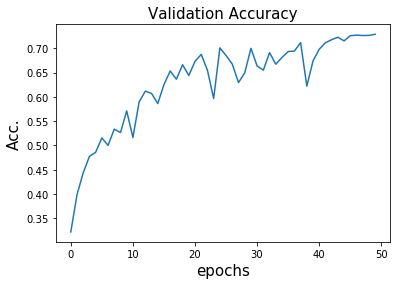

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['val_accuracy'])
plt.title('Validation Accuracy', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('Acc.', fontsize=15)

plt.show()

## Test Accuracy

test accuracy 측정 결과 **65% 이상**이 나와야 한다.

In [ ]:
my_inception.evaluate(x_test, y_test)